# Segmentation Evaluation <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F34_Segmentation_Evaluation.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

Evaluating segmentation algorithms is most often done using reference data to which you compare your results. 

In the medical domain reference data is commonly obtained via manual segmentation by an expert (don't forget to thank your clinical colleagues for their hard work). When you are resource limited, the reference data may be defined by a single expert. This is less than ideal. When multiple experts provide you with their input then you can potentially combine them to obtain reference data that is closer to the ever elusive "ground truth". In this notebook we show two approaches to combining input from multiple observers, majority vote and the Simultaneous Truth and Performance Level
Estimation [(STAPLE)](https://www.ncbi.nlm.nih.gov/pubmed/15250643).

Once we have a reference, we compare the algorithm's performance using multiple criteria, as usually there is no single evaluation measure that conveys all of the relevant information. In this notebook we illustrate the use of the following evaluation criteria:
* Overlap measures:
  * Jaccard and Dice coefficients 
  * false negative and false positive errors
* Surface distance measures:
  * Hausdorff distance (symmetric)
  * mean, median, max and standard deviation between surfaces
* Volume measures:
  * volume similarity $ \frac{2*(v1-v2)}{v1+v2}$

The relevant criteria are task dependent, so you need to ask yourself whether you are interested in detecting spurious errors or not (mean or max surface distance), whether over/under segmentation should be differentiated (volume similarity and Dice or just Dice), and what is the ratio between acceptable errors and the size of the segmented object (Dice coefficient may be too sensitive to small errors when the segmented object is small and not sensitive enough to large errors when the segmented object is large).

The data we use in the notebook is a set of manually segmented liver tumors from a single clinical CT scan. A larger dataset (four scans) is freely available from this [MIDAS repository](http://www.insight-journal.org/midas/collection/view/38). The relevant publication is: T. Popa et al., "Tumor Volume Measurement and Volume Measurement Comparison Plug-ins for VolView Using ITK", SPIE Medical Imaging: Visualization, Image-Guided Procedures, and Display, 2006.

<b>Note</b>: The approach described here can also be used to evaluate Registration, as illustrated in the [free form deformation notebook](65_Registration_FFD.ipynb).

In [1]:
import SimpleITK as sitk

import numpy as np

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

%matplotlib inline
import matplotlib.pyplot as plt
import gui

from ipywidgets import interact, fixed

## Utility method for display

In [2]:
def display_with_overlay(
    segmentation_number, slice_number, image, segs, window_min, window_max
):
    """
    Display a CT slice with segmented contours overlaid onto it. The contours are the edges of
    the labeled regions.
    """
    img = image[:, :, slice_number]
    msk = segs[segmentation_number][:, :, slice_number]
    overlay_img = sitk.LabelMapContourOverlay(
        sitk.Cast(msk, sitk.sitkLabelUInt8),
        sitk.Cast(
            sitk.IntensityWindowing(
                img, windowMinimum=window_min, windowMaximum=window_max
            ),
            sitk.sitkUInt8,
        ),
        opacity=1,
        contourThickness=[2, 2],
    )
    # We assume the original slice is isotropic, otherwise the display would be distorted
    plt.imshow(sitk.GetArrayViewFromImage(overlay_img))
    plt.axis("off")
    plt.show()

## Fetch the data

Retrieve a single CT scan and three manual delineations of a liver tumor. Visual inspection of the data highlights the variability between experts. 

In [3]:
image = sitk.ReadImage(fdata("liverTumorSegmentations/Patient01Homo.mha"))
segmentation_file_names = [
    "liverTumorSegmentations/Patient01Homo_Rad01.mha",
    "liverTumorSegmentations/Patient01Homo_Rad02.mha",
    "liverTumorSegmentations/Patient01Homo_Rad03.mha",
]

segmentations = [
    sitk.ReadImage(fdata(file_name), sitk.sitkUInt8)
    for file_name in segmentation_file_names
]

interact(
    display_with_overlay,
    segmentation_number=(0, len(segmentations) - 1),
    slice_number=(0, image.GetSize()[2] - 1),
    image=fixed(image),
    segs=fixed(segmentations),
    window_min=fixed(-1024),
    window_max=fixed(976),
);

Fetching liverTumorSegmentations/Patient01Homo.mha
Fetching liverTumorSegmentations/Patient01Homo_Rad01.mha
Fetching liverTumorSegmentations/Patient01Homo_Rad02.mha
Fetching liverTumorSegmentations/Patient01Homo_Rad03.mha


interactive(children=(IntSlider(value=1, description='segmentation_number', max=2), IntSlider(value=48, descri…

## Derive a reference

There are a variety of ways to derive a reference segmentation from multiple expert inputs. Several options, there are more, are described in "A comparison of ground truth estimation methods", A. M. Biancardi, A. C. Jirapatnakul, A. P. Reeves. 

Two methods that are available in SimpleITK are <b>majority vote</b> and the <b>STAPLE</b> algorithm.

In [4]:
# Use majority voting to obtain the reference segmentation. Note that this filter does not resolve ties. In case of
# ties, it will assign max_label_value+1 or a user specified label value (labelForUndecidedPixels) to the result.
# Before using the results of this filter you will have to check whether there were ties and modify the results to
# resolve the ties in a manner that makes sense for your task. The filter implicitly accommodates multiple labels.
labelForUndecidedPixels = 10
reference_segmentation_majority_vote = sitk.LabelVoting(
    segmentations, labelForUndecidedPixels
)

manual_plus_majority_vote = list(segmentations)
# Append the reference segmentation to the list of manual segmentations
manual_plus_majority_vote.append(reference_segmentation_majority_vote)

interact(
    display_with_overlay,
    segmentation_number=(0, len(manual_plus_majority_vote) - 1),
    slice_number=(0, image.GetSize()[1] - 1),
    image=fixed(image),
    segs=fixed(manual_plus_majority_vote),
    window_min=fixed(-1024),
    window_max=fixed(976),
);

interactive(children=(IntSlider(value=1, description='segmentation_number', max=3), IntSlider(value=88, descri…

In [5]:
# Use the STAPLE algorithm to obtain the reference segmentation. This implementation of the original algorithm
# combines a single label from multiple segmentations, the label is user specified. The result of the
# filter is the voxel's probability of belonging to the foreground. We then have to threshold the result to obtain
# a reference binary segmentation.
foregroundValue = 1
threshold = 0.95
reference_segmentation_STAPLE_probabilities = sitk.STAPLE(
    segmentations, foregroundValue
)
# We use the overloaded operator to perform thresholding, another option is to use the BinaryThreshold function.
reference_segmentation_STAPLE = reference_segmentation_STAPLE_probabilities > threshold

manual_plus_staple = list(segmentations)
# Append the reference segmentation to the list of manual segmentations
manual_plus_staple.append(reference_segmentation_STAPLE)

interact(
    display_with_overlay,
    segmentation_number=(0, len(manual_plus_staple) - 1),
    slice_number=(0, image.GetSize()[1] - 1),
    image=fixed(image),
    segs=fixed(manual_plus_staple),
    window_min=fixed(-1024),
    window_max=fixed(976),
);

interactive(children=(IntSlider(value=1, description='segmentation_number', max=3), IntSlider(value=88, descri…

## Evaluate segmentations using the reference

Once we derive a reference from our experts input we can compare segmentation results to it.

Note that in this notebook we compare the expert segmentations to the reference derived from them. This is not relevant for algorithm evaluation, but it can potentially be used to rank your experts.

In this specific implementation we take advantage of the fact that we have a binary segmentation with 1 for foreground and 0 for background.

In [6]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice, volume_similarity, false_negative, false_positive = range(5)


class SurfaceDistanceMeasures(Enum):
    (
        hausdorff_distance,
        mean_surface_distance,
        median_surface_distance,
        std_surface_distance,
        max_surface_distance,
    ) = range(5)


# Select which reference we want to use (majority vote or STAPLE)
reference_segmentation = reference_segmentation_STAPLE

# Empty numpy arrays to hold the results
overlap_results = np.zeros(
    (len(segmentations), len(OverlapMeasures.__members__.items()))
)
surface_distance_results = np.zeros(
    (len(segmentations), len(SurfaceDistanceMeasures.__members__.items()))
)

# Compute the evaluation criteria

# Note that for the overlap measures filter, because we are dealing with a single label we
# use the combined, all labels, evaluation measures without passing a specific label to the methods.
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

# Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside
# relationship, is irrelevant)
label = 1
reference_distance_map = sitk.Abs(
    sitk.SignedMaurerDistanceMap(
        reference_segmentation, squaredDistance=False, useImageSpacing=True
    )
)
reference_surface = sitk.LabelContour(reference_segmentation)

statistics_image_filter = sitk.StatisticsImageFilter()
# Get the number of pixels in the reference surface by counting all pixels that are 1.
statistics_image_filter.Execute(reference_surface)
num_reference_surface_pixels = int(statistics_image_filter.GetSum())

for i, seg in enumerate(segmentations):
    # Overlap measures
    overlap_measures_filter.Execute(reference_segmentation, seg)
    overlap_results[
        i, OverlapMeasures.jaccard.value
    ] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_results[
        i, OverlapMeasures.dice.value
    ] = overlap_measures_filter.GetDiceCoefficient()
    overlap_results[
        i, OverlapMeasures.volume_similarity.value
    ] = overlap_measures_filter.GetVolumeSimilarity()
    overlap_results[
        i, OverlapMeasures.false_negative.value
    ] = overlap_measures_filter.GetFalseNegativeError()
    overlap_results[
        i, OverlapMeasures.false_positive.value
    ] = overlap_measures_filter.GetFalsePositiveError()
    # Hausdorff distance
    hausdorff_distance_filter.Execute(reference_segmentation, seg)

    surface_distance_results[
        i, SurfaceDistanceMeasures.hausdorff_distance.value
    ] = hausdorff_distance_filter.GetHausdorffDistance()
    # Symmetric surface distance measures
    segmented_distance_map = sitk.Abs(
        sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True)
    )
    segmented_surface = sitk.LabelContour(seg)

    # Multiply the binary surface segmentations with the distance maps. The resulting distance
    # maps contain non-zero values only on the surface (they can also contain zero on the surface)
    seg2ref_distance_map = reference_distance_map * sitk.Cast(
        segmented_surface, sitk.sitkFloat32
    )
    ref2seg_distance_map = segmented_distance_map * sitk.Cast(
        reference_surface, sitk.sitkFloat32
    )

    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(segmented_surface)
    num_segmented_surface_pixels = int(statistics_image_filter.GetSum())

    # Get all non-zero distances and then add zero distances if required.
    seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr != 0])
    seg2ref_distances = seg2ref_distances + list(
        np.zeros(num_segmented_surface_pixels - len(seg2ref_distances))
    )
    ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr != 0])
    ref2seg_distances = ref2seg_distances + list(
        np.zeros(num_reference_surface_pixels - len(ref2seg_distances))
    )

    all_surface_distances = seg2ref_distances + ref2seg_distances

    # The maximum of the symmetric surface distances is the Hausdorff distance between the surfaces. In
    # general, it is not equal to the Hausdorff distance between all voxel/pixel points of the two
    # segmentations, though in our case it is. More on this below.
    surface_distance_results[
        i, SurfaceDistanceMeasures.mean_surface_distance.value
    ] = np.mean(all_surface_distances)
    surface_distance_results[
        i, SurfaceDistanceMeasures.median_surface_distance.value
    ] = np.median(all_surface_distances)
    surface_distance_results[
        i, SurfaceDistanceMeasures.std_surface_distance.value
    ] = np.std(all_surface_distances)
    surface_distance_results[
        i, SurfaceDistanceMeasures.max_surface_distance.value
    ] = np.max(all_surface_distances)

# Print the matrices
np.set_printoptions(precision=3)
print(overlap_results)
print(surface_distance_results)

[[ 0.82   0.901  0.052  0.075  0.122]
 [ 0.881  0.937 -0.013  0.069  0.057]
 [ 0.843  0.915 -0.088  0.124  0.044]]
[[4.905 0.459 0.    0.85  4.905]
 [3.469 0.29  0.    0.689 3.469]
 [5.203 0.431 0.    0.831 5.203]]


## Improved output

If the [pandas](http://pandas.pydata.org/) package is installed in your Python environment then you can easily produce high quality output. 

,jaccard,dice,volume_similarity,false_negative,false_positive
0,0.820,0.901,0.052,0.075,0.122
1,0.881,0.937,-0.013,0.069,0.057
2,0.843,0.915,-0.088,0.124,0.044


,hausdorff_distance,mean_surface_distance,median_surface_distance,std_surface_distance,max_surface_distance
0,4.905,0.459,0.000,0.850,4.905
1,3.469,0.290,0.000,0.689,3.469
2,5.203,0.431,0.000,0.831,5.203


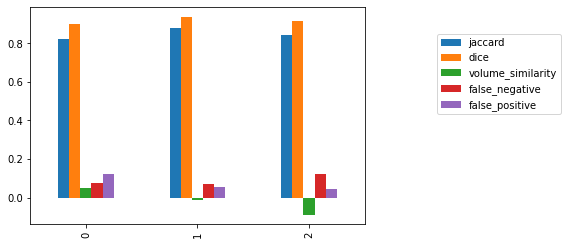

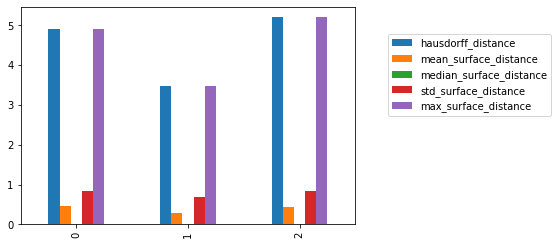

In [7]:
import pandas as pd
from IPython.display import display, HTML

# Graft our results matrix into pandas data frames
overlap_results_df = pd.DataFrame(
    data=overlap_results,
    index=list(range(len(segmentations))),
    columns=[name for name, _ in OverlapMeasures.__members__.items()],
)
surface_distance_results_df = pd.DataFrame(
    data=surface_distance_results,
    index=list(range(len(segmentations))),
    columns=[name for name, _ in SurfaceDistanceMeasures.__members__.items()],
)

# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: "%.3f" % x)))
display(HTML(surface_distance_results_df.to_html(float_format=lambda x: "%.3f" % x)))
overlap_results_df.plot(kind="bar").legend(bbox_to_anchor=(1.6, 0.9))
surface_distance_results_df.plot(kind="bar").legend(bbox_to_anchor=(1.6, 0.9))

You can also export the data as a table for your LaTeX manuscript using the [to_latex](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_latex.html) function.
<b>Note</b>: You will need to add the \usepackage{booktabs} to your LaTeX document's preamble. 

To create the minimal LaTeX document which will allow you to see the difference between the tables below, copy paste:

\documentclass{article}

\usepackage{booktabs}

\begin{document}

paste the tables here

\end{document}



In [8]:
# The formatting of the table using the default settings is less than ideal
print(overlap_results_df.to_latex())

# We can improve on this by specifying the table's column format and the float format
print(
    overlap_results_df.to_latex(
        column_format="ccccccc", float_format=lambda x: "%.3f" % x
    )
)

\begin{tabular}{lrrrrr}
\toprule
{} &   jaccard &      dice &  volume\_similarity &  false\_negative &  false\_positive \\
\midrule
0 &  0.820124 &  0.901174 &           0.052253 &        0.074650 &        0.121771 \\
1 &  0.881379 &  0.936950 &          -0.013196 &        0.069192 &        0.056827 \\
2 &  0.842653 &  0.914608 &          -0.087509 &        0.123732 &        0.043542 \\
\bottomrule
\end{tabular}

\begin{tabular}{ccccccc}
\toprule
{} &  jaccard &  dice &  volume\_similarity &  false\_negative &  false\_positive \\
\midrule
0 &    0.820 & 0.901 &              0.052 &           0.075 &           0.122 \\
1 &    0.881 & 0.937 &             -0.013 &           0.069 &           0.057 \\
2 &    0.843 & 0.915 &             -0.088 &           0.124 &           0.044 \\
\bottomrule
\end{tabular}



## Segmentation Representation and the Hausdorff Distance

The results of segmentation can be represented as a set of closed contours/surfaces or as the discrete set of points (pixels/voxels) belonging to the segmented objects. Ideally using either representation would yield the same values for the segmentation evaluation metrics. Unfortunately, the Hausdorff distance computed directly from each of these representations will generally not yield the same results. In some cases, such as the one above, the two values do match (table entries hausdorff_distance and max_surface_distance).

The following example illustrates that the Hausdorff distance for the contour/surface representation and the discrete point set representing the segmented object differ, and that there is no correlation between the two.

Our object of interest is annulus shaped (e.g. myocardium in short axis MRI). It has an internal radius, $r$, and an external radius $R>r$. We over-segmented the object and obtained a filled circle of radius $R$.
 
The contour/surface based Hausdorff distance is $R-r$, the distance between external contours is zero and between internal and external contours is $R-r$. The pixel/voxel object based Hausdorff distance is $r$, corresponding to the distance between the center point in the over-segmented result to the inner circle contour. For different values of $r$ we can either have $R-r \geq r$ or $R-r \leq r$.

**Note**: Both computations of Hausdorff distance are valid, though the common approach is to use the pixel/voxel based representation for computing the Hausdorff distance.

The following cells show these differences in detail.

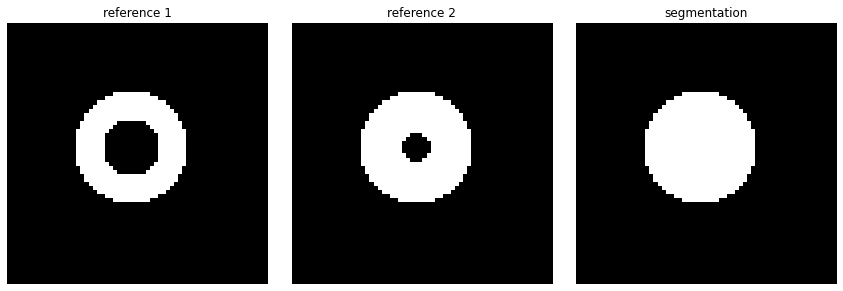

In [9]:
# Create our segmentations and display
image_size = [64, 64]
circle_center = [30, 30]
circle_radius = [20, 20]

# A filled circle with radius R
seg = (
    sitk.GaussianSource(sitk.sitkUInt8, image_size, circle_radius, circle_center) > 200
)
# A torus with inner radius r
reference_segmentation1 = seg - (
    sitk.GaussianSource(sitk.sitkUInt8, image_size, circle_radius, circle_center) > 240
)
# A torus with inner radius r_2<r
reference_segmentation2 = seg - (
    sitk.GaussianSource(sitk.sitkUInt8, image_size, circle_radius, circle_center) > 250
)

gui.multi_image_display2D(
    [reference_segmentation1, reference_segmentation2, seg],
    ["reference 1", "reference 2", "segmentation"],
    figure_size=(12, 4),
);

In [10]:
def surface_hausdorff_distance(reference_segmentation, seg):
    """
    Compute symmetric surface distances and take the maximum.
    """
    reference_distance_map = sitk.Abs(
        sitk.SignedMaurerDistanceMap(
            reference_segmentation, squaredDistance=False, useImageSpacing=True
        )
    )
    reference_surface = sitk.LabelContour(reference_segmentation)

    statistics_image_filter = sitk.StatisticsImageFilter()
    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(reference_surface)
    num_reference_surface_pixels = int(statistics_image_filter.GetSum())

    segmented_distance_map = sitk.Abs(
        sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True)
    )
    segmented_surface = sitk.LabelContour(seg)

    # Multiply the binary surface segmentations with the distance maps. The resulting distance
    # maps contain non-zero values only on the surface (they can also contain zero on the surface)
    seg2ref_distance_map = reference_distance_map * sitk.Cast(
        segmented_surface, sitk.sitkFloat32
    )
    ref2seg_distance_map = segmented_distance_map * sitk.Cast(
        reference_surface, sitk.sitkFloat32
    )

    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(segmented_surface)
    num_segmented_surface_pixels = int(statistics_image_filter.GetSum())

    # Get all non-zero distances and then add zero distances if required.
    seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr != 0])
    seg2ref_distances = seg2ref_distances + list(
        np.zeros(num_segmented_surface_pixels - len(seg2ref_distances))
    )
    ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr != 0])
    ref2seg_distances = ref2seg_distances + list(
        np.zeros(num_reference_surface_pixels - len(ref2seg_distances))
    )
    all_surface_distances = seg2ref_distances + ref2seg_distances
    return np.max(all_surface_distances)


hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

# Use reference1, larger inner annulus radius, the surface based computation
# has a smaller difference.
hausdorff_distance_filter.Execute(reference_segmentation1, seg)
print(
    "HausdorffDistanceImageFilter result (reference1-segmentation): "
    + str(hausdorff_distance_filter.GetHausdorffDistance())
)
print(
    "Surface Hausdorff result (reference1-segmentation): "
    + str(surface_hausdorff_distance(reference_segmentation1, seg))
)

# Use reference2, smaller inner annulus radius, the surface based computation
# has a larger difference.
hausdorff_distance_filter.Execute(reference_segmentation2, seg)
print(
    "HausdorffDistanceImageFilter result (reference2-segmentation): "
    + str(hausdorff_distance_filter.GetHausdorffDistance())
)
print(
    "Surface Hausdorff result (reference2-segmentation): "
    + str(surface_hausdorff_distance(reference_segmentation2, seg))
)

HausdorffDistanceImageFilter result (reference1-segmentation): 7.0
Surface Hausdorff result (reference1-segmentation): 6.0
HausdorffDistanceImageFilter result (reference2-segmentation): 3.605551275463989
Surface Hausdorff result (reference2-segmentation): 8.9442720413208
